# FCS measurement of freely diffusing Alexa 488

Note that the original dataset used for this analysis contains 200 spc files. For illustrative purposes, the first ten files have been included in this example.

In [1]:
%load_ext autoreload
%autoreload 2

In [82]:
from copy import deepcopy
from glob import glob
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif":"Computer Modern",
    "font.sans-serif":"Arial",
    "font.size": 14,
    "mathtext.fontset": "cm",
    "svg.fonttype": "none",
})

import numpy as np
from scipy.optimize import curve_fit, least_squares
from tqdm.notebook import tqdm, trange
import xarray as xr

import sys
sys.path.append(r"D:\Dropbox\code\pyTCSPC")

import pyTCSPC as pc

import multipletau as mt

In [3]:
# set directory containing all spc files
data_dir = "A488_data/"

# get path of all spc files
spc_fns = glob(data_dir + "/*.spc")
len(spc_fns)

200

In [6]:
# initial processing of spc files
for spc_fn in tqdm(spc_fns):
    # this command reads the spc file and saves the data in it to a NetCDF (.nc) file that is used for downstream analysis
    spc = pc.SPC(spc_fn, pixels_per_line=1, nlines=1, n_lines_skip=0, read_paired_sdt=False, show_progress=False, save_images=False)

  0%|          | 0/200 [00:00<?, ?it/s]

In [56]:
# calculate correlation functions

nc_fns = [Path(spc_fn).with_suffix(".nc") for spc_fn in spc_fns]

acfs = []
nphotons = []
for nc_fn in tqdm(nc_fns):
    lag_time, curr_acf, curr_nphotons = pc.calc_acf(nc_fn, maxtime_subtraj=1)
    acfs.append(curr_acf)
    nphotons.append(curr_nphotons)

  0%|          | 0/200 [00:00<?, ?it/s]

In [57]:
mean_acf = 1 + np.array([nphotons[i]*acfs[i] for i in range(len(acfs))]).sum(axis=0)/np.sum(nphotons)

(array([0.45683612, 0.4223979 , 1.00030531]),
 array([[ 1.15561975e-04,  1.62120478e-04,  2.77349971e-07],
        [ 1.62120478e-04,  4.53118115e-04, -1.40397974e-06],
        [ 2.77349971e-07, -1.40397974e-06,  4.13579372e-08]]))

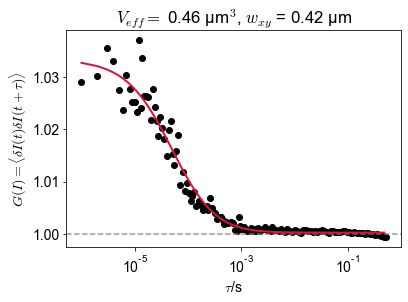

In [86]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lag_time, mean_acf, "o", color="k")

ax.axhline(y=1, color="gray", alpha=0.8, linestyle="--")
ax.set_xscale("log")
ax.set_xlabel(r"$\tau$/s")
ax.set_ylabel(r"$G(I)= \langle \delta I(t) \delta I (t+\tau) \rangle$")

# fit to model

def diffusion_acf(t, Veff, wxy, Ginf):
    D = 435 # um2/s
    chi2 = 1.1
    C = 60.22 # um^-3
    wz = np.power(2/np.pi,3/2) * Veff / (wxy**2)
    prefac = 1/(Veff*chi2*C)
    Txy    = 1/(1+(8*D*t/(wxy**2)))
    Tz     = 1/(1+(8*D*t/(wz**2)))
    return prefac*Txy*np.sqrt(Tz) + Ginf

## bounds to use for fitting
istartlag, iendlag = 0, -1

## perform fitting
popt, pcov = curve_fit(diffusion_acf, lag_time[istartlag:iendlag], mean_acf[istartlag:iendlag], p0=(0.3, 0.4, 1), sigma=np.sqrt(mean_acf[istartlag:iendlag]))
yy = diffusion_acf(lag_time, *popt)

## and show fit
ax.plot(lag_time[istartlag:iendlag], yy[istartlag:iendlag], color="crimson", lw=2)
ax.set_title(r"$V_{eff} =$" + f" {popt[0]:2.2f} " + r"μm$^3$, $w_{xy}$" + f" = {popt[1]:2.2f} μm")

plt.savefig(f"A488_FCS.png", dpi=300, bbox_inches="tight")
popt, pcov